In [1]:
'''
Import whatever needs to be imported
'''

#Enable interactive plot
%matplotlib notebook

import os
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy.linalg as LA
from itertools import product

hypar_dir = os.environ.get('HYPAR_DIR')
hypar_dir_python = hypar_dir + '/Examples/Python'
sys.path.append(hypar_dir_python)

lasdi_dir = os.environ.get('LASDI_DIR')
sys.path.append(lasdi_dir)

import modHyParUtils as hyparutils
import modLaSDIUtils as lasdiutils
import modAutoEncoder as autoencoder

from LaSDI import LaSDI

In [2]:
'''
Set up the simulation parameters
'''
train_sim_path = 'training_data'
sim_inp_data = hyparutils.readHyParInpFile(train_sim_path+'/simulation.inp')
solver_inp_data = hyparutils.readHyParInpFile(train_sim_path+'/solver.inp')

if not sim_inp_data:
    nsims = 1
else:
    nsims = int(sim_inp_data['nsims'][0])
    
print('Number of simulations: ', nsims)

if solver_inp_data['op_overwrite'] != 'no':
    raise Exception("op_overwrite must be 'no' in solver.inp.")

if solver_inp_data['op_file_format'] != 'binary':
    raise Exception("op_file_format must be 'binary' in solver.inp.")

    
ndims = int(solver_inp_data['ndims'][0])
nvars = int(solver_inp_data['nvars'][0])
size = np.int32(solver_inp_data['size'][0])
ndof = np.product(size)*nvars
niter = int(solver_inp_data['n_iter'][0])
dt = float(solver_inp_data['dt'][0])
t_final = dt*niter

op_write_iter = int(solver_inp_data['file_op_iter'][0])
dt_snapshots = op_write_iter*dt
n_snapshots = int(niter/op_write_iter) + 1

print('Simulation parameters:')
print('  ndims = ', ndims)
print('  nvars = ', nvars)
print('  grid size = ', size)
print('  ndof = ', ndof)
print('  simulation dt = ', dt)
print('  niter = ', niter)
print('  final time = ', t_final)
print('  snapshot dt = ', dt_snapshots)
print('  number of snapshots = ', n_snapshots)

Number of simulations:  4
Simulation parameters:
  ndims =  1
  nvars =  1
  grid size =  64
  ndof =  64
  simulation dt =  0.0025
  niter =  400
  final time =  1.0
  snapshot dt =  0.0025
  number of snapshots =  401


Solution snapshot shape:  (1604, 64)


<IPython.core.display.Javascript object>


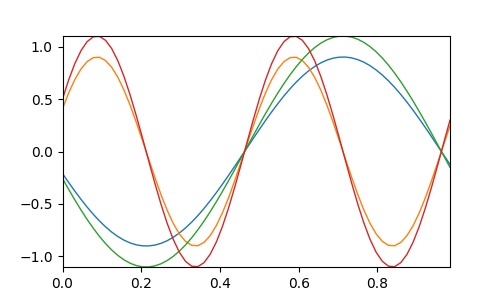

In [3]:
'''
Load simulation data (solution snapshots)
'''

x,solution_snapshots = hyparutils.getSolutionSnapshots(train_sim_path, nsims, n_snapshots, ndims, nvars, size)
solution_snapshots = np.float32(solution_snapshots)
print('Solution snapshot shape: ', solution_snapshots.shape)

def animate(i):
    for s in range(nsims):
        solution_snapshots_sim = solution_snapshots[s*n_snapshots:(s+1)*n_snapshots]
        lines[s].set_ydata(solution_snapshots_sim[i, :])

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.set(xlim=(np.min(x), np.max(x)), ylim=(np.min(solution_snapshots), np.max(solution_snapshots)))
lines = [None]*nsims
for s in range(nsims):
    solution_snapshots_sim = solution_snapshots[s*n_snapshots:(s+1)*n_snapshots]
    lines[s] = ax.plot(x, solution_snapshots_sim[0, :], lw=1)[0]

anim = FuncAnimation(fig, animate, interval=10, frames=n_snapshots, blit=False)
plt.draw()
plt.show()

In [4]:
# define testset and trainset indices
test_frac = 0.4
print('Test fraction: ', test_frac)
test_ind = np.random.permutation(np.arange(solution_snapshots.shape[0]))[:int(test_frac*solution_snapshots.shape[0])]
train_ind = np.setdiff1d(np.arange(solution_snapshots.shape[0]),test_ind)

# set trainset and testset
trainset = solution_snapshots[train_ind]
testset = solution_snapshots[test_ind]
print('Training data shape: ', trainset.shape)
print('Test data shape: ', testset.shape)

Test fraction:  0.4
Training data shape:  (963, 64)
Test data shape:  (641, 64)


Using device:  cpu
Sparsity in 64 by 792 mask: 95.45%

--------checkpoint not restored--------

Sparsity in 64 by 792 mask: 95.45%

Start first training... m=64, f=4, M1=128, M2=792


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch 60/600, Learning rate 0.001
----------
train MSELoss: 9.010958421446126e-06
test MSELoss: 1.0587496967637888e-05

Epoch 120/600, Learning rate 0.0001
----------
train MSELoss: 3.2422921442883276e-06
test MSELoss: 3.1690186026590624e-06

Epoch 180/600, Learning rate 1e-05
----------
train MSELoss: 1.943215774467042e-06
test MSELoss: 2.000506245631314e-06

Epoch 240/600, Learning rate 1e-05
----------
train MSELoss: 1.8138880892008707e-06
test MSELoss: 1.855239441414165e-06

Epoch 300/600, Learning rate 1e-05
----------
train MSELoss: 1.626550773214837e-06
test MSELoss: 1.6679009664860725e-06

Epoch 360/600, Learning rate 1e-05
----------
train MSELoss: 1.4876232740942418e-06
test MSELoss: 1.5102719298483125e-06

Epoch 420/600, Learning rate 1e-05
----------
train MSELoss: 1.3393068269463868e-06
test MSELoss: 1.384057465576076e-06

Epoch 480/600, Learning rate 1e-05
----------
train MSELoss: 1.2281360634633086e-06
test MSELoss: 1.2553973221639607e-06

Epoch 540/600, Learning rate 

<IPython.core.display.Javascript object>


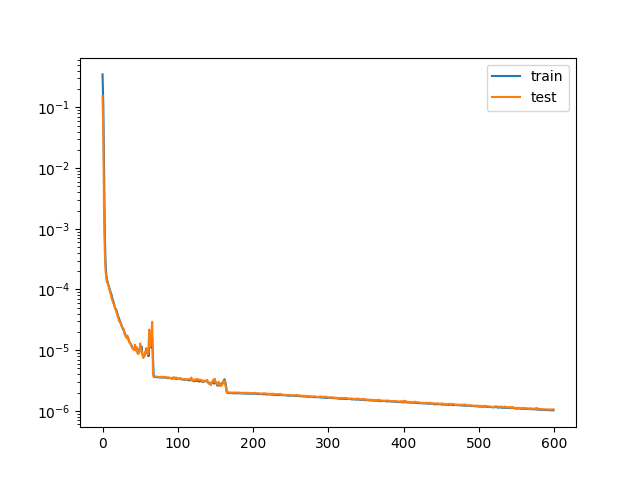


checkpoint removed


In [5]:
# set device
device = autoencoder.getDevice()
print('Using device: ', device)

# set encoder and decoder types, activation function, etc.
encoder_class = autoencoder.Encoder
decoder_class = autoencoder.Decoder
f_activation = autoencoder.SiLU

# set the number of nodes in each layer
m = ndof
f = 4
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m
mask = lasdiutils.create_mask_1d(m,b,db)

# set batch_size, number of epochs, patience for early stop
batch_size = 20
num_epochs = 600
num_epochs_print = num_epochs//10

# filename
AE_fname = 'AE_git.tar'

encoder, decoder = autoencoder.createAE(encoder_class,
                                        decoder_class,
                                        f_activation,
                                        mask,
                                        m, f, M1, M2,
                                        device )

autoencoder.trainAE(encoder, 
                    decoder,
                    trainset,
                    testset,
                    batch_size,
                    num_epochs,
                    num_epochs_print,
                    AE_fname )

Parameter space:
 [[0.9 1. ]
 [0.9 2. ]
 [1.1 1. ]
 [1.1 2. ]]


<IPython.core.display.Javascript object>


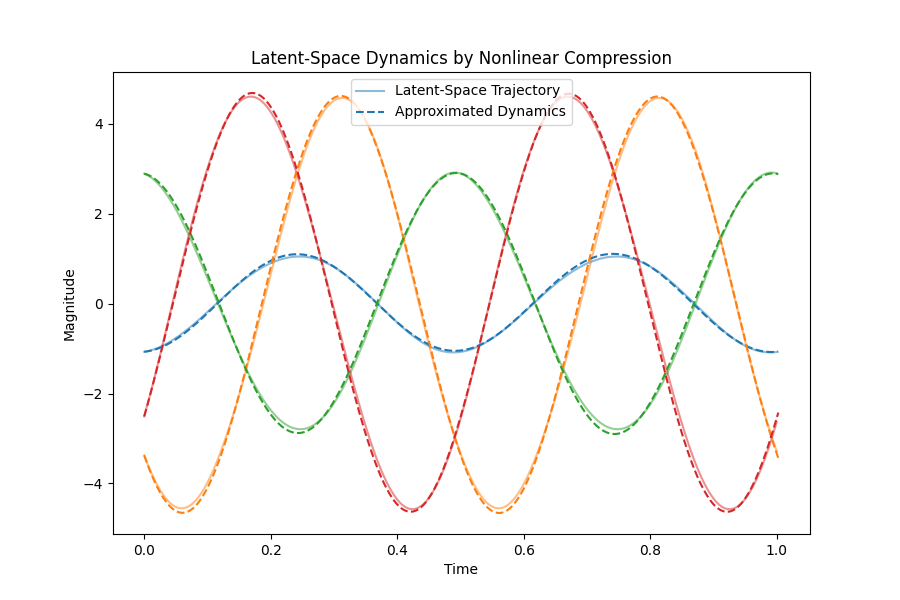

(x0)' = -0.142 1 + 0.682 x0 + 0.534 x1 + 5.098 x2 + 4.208 x3
(x1)' = -0.187 1 + -0.641 x0 + -0.633 x1 + -6.232 x2 + 9.874 x3
(x2)' = 0.316 1 + -4.804 x0 + 5.736 x1 + -0.127 x2 + -4.434 x3
(x3)' = -0.120 1 + -4.981 x0 + -10.291 x1 + 3.247 x2 + 0.074 x3


In [6]:
'''
Generate LaSDI-NM Model
'''
param_data = hyparutils.readHyParInpFile(train_sim_path+'/parameters.dat')
amplitude_arr = np.float32(param_data['amplitude'])
wavenumber_arr = np.float32(param_data['wavenumber'])
P = list(product(amplitude_arr,wavenumber_arr))
P = np.array(P)
print('Parameter space:\n', P)

encoder, decoder = autoencoder.readAEFromFile(  encoder_class,
                                                decoder_class,
                                                f_activation,
                                                mask,
                                                m, f, M1, M2,
                                                device,
                                                AE_fname )

latent_space_snapshots = autoencoder.encodedSnapshots(  encoder,
                                                        solution_snapshots,
                                                        niter+1,
                                                        device )
LaSDI_model = LaSDI(encoder, decoder, NN = True, device = device)
LaSDI_model.train_dynamics(latent_space_snapshots, P, dt_snapshots)

Test simulation parameters:
  simulation dt =  0.002
  niter =  4000
  final time =  8.0
  snapshot dt =  0.02
  number of snapshots =  401
FOM wctime: 0.311841
LaSDI wctime:  0.3225438594818115


<IPython.core.display.Javascript object>


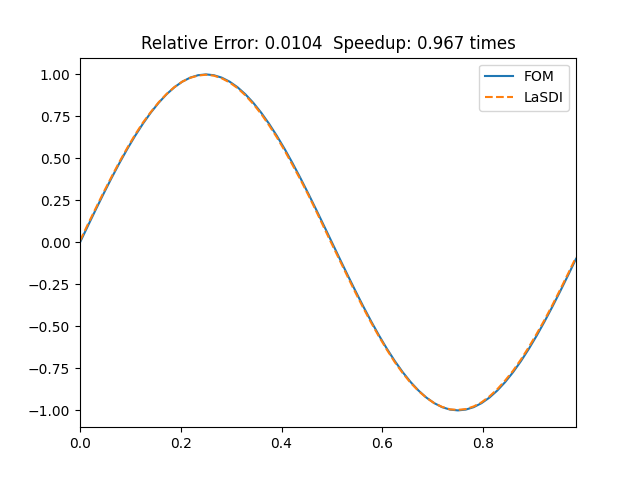

<IPython.core.display.Javascript object>


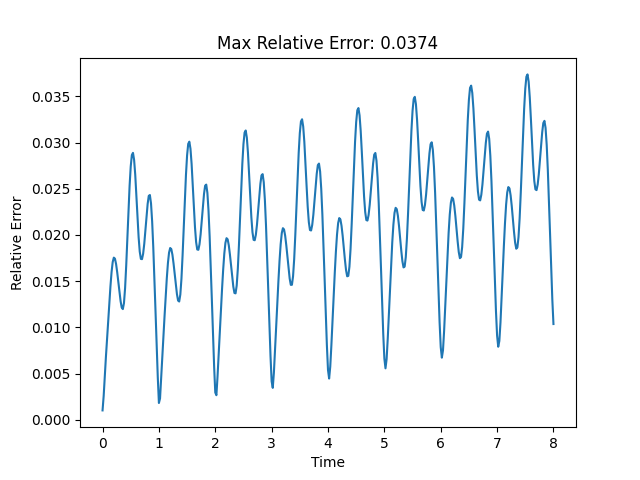

In [7]:
'''
Load test simulation data (solution snapshots)
'''
test_sim_path = 'test'
solver_inp_data = hyparutils.readHyParInpFile(test_sim_path+'/solver.inp')

if solver_inp_data['op_overwrite'] != 'no':
    raise Exception("op_overwrite must be 'no' in solver.inp.")

if solver_inp_data['op_file_format'] != 'binary':
    raise Exception("op_file_format must be 'binary' in solver.inp.")

niter = int(solver_inp_data['n_iter'])
dt = float(solver_inp_data['dt'])
t_final = dt*niter
op_write_iter = int(solver_inp_data['file_op_iter'])
dt_snapshots = op_write_iter*dt
n_snapshots = int(niter/op_write_iter) + 1

print('Test simulation parameters:')
print('  simulation dt = ', dt)
print('  niter = ', niter)
print('  final time = ', t_final)
print('  snapshot dt = ', dt_snapshots)
print('  number of snapshots = ', n_snapshots)

x,solution_snapshots_FOM = hyparutils.getSolutionSnapshots(test_sim_path, 1, n_snapshots, ndims, nvars, size)
solution_snapshots_FOM = np.float32(solution_snapshots_FOM)

FOM_err, FOM_time, FOM_totaltime = hyparutils.readHyParErrFile(test_sim_path, ndims)

t_arr = np.linspace(0, t_final, int(niter/op_write_iter)+1)

start = time.time()
FOM_recon = LaSDI_model.generate_ROM(solution_snapshots_FOM[0], np.array([1.0, 1.0]), t_arr)
LaSDI_time = time.time()-start

print('FOM wctime:', FOM_time)
print('LaSDI wctime: ', LaSDI_time)

fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from LaSDI-NM', y = 1.05)
ax.set_title('Relative Error: {:.3}  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-solution_snapshots_FOM[-1])/LA.norm(solution_snapshots_FOM[-1]), FOM_time/LaSDI_time))
ax.plot(x,solution_snapshots_FOM[-1], label = 'FOM')
ax.plot(x, FOM_recon[-1],'--', label = 'LaSDI')
ax.legend()
ax.set_xlim(np.min(x),np.max(x))

FOM_re = np.empty(n_snapshots)
for i in range(n_snapshots):
    FOM_re[i] = LA.norm(FOM_recon[i]-solution_snapshots_FOM[i])/LA.norm(solution_snapshots_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}'.format(np.amax(FOM_re)))
ax.plot(t_arr, FOM_re)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error')
plt.show()